# Skwonk: Fuzzy Find and Replace using FASTA Algorithm

## Introduction

In this notebook, we present **Skwonk**, an algorithm designed to perform fuzzy find and replace operations on a code-base. Skwonk leverages the **FASTA** algorithm, commonly used in bioinformatics for sequence alignment, to efficiently locate and replace code snippets that are similar but not necessarily identical to the target pattern.

### Key Features of Skwonk:

- **Fuzzy Matching**: Allows for approximate matching, accommodating minor differences in code.
- **Replace Functionality**: Replaces matched code segments with the specified replacement code.
- **Efficiency**: Optimized for large code-bases through the use of heuristic methods.

## Table of Contents

1. [Overview of the FASTA Algorithm](#overview-fasta)
2. [Skwonk Algorithm Explanation](#skwonk-algorithm)
3. [Implementation](#implementation)
    - [FASTA Algorithm](#fasta-implementation)
    - [Skwonk Algorithm](#skwonk-implementation)
4. [Usage Example](#usage-example)
5. [Performance Analysis](#performance-analysis)
6. [Conclusion](#conclusion)
7. [References](#references)

## 1. Overview of the FASTA Algorithm <a id="overview-fasta"></a>

The FASTA algorithm is a heuristic method for sequence alignment, which is widely used in bioinformatics. It operates by finding regions of local similarity between sequences and then aligning these regions.

### Key Steps in FASTA:

1. **K-tuple Identification**: Identifies exact matches of short subsequences (k-tuples) between the target and query sequences.
2. **Diagonal Scoring**: Scores the diagonals based on the k-tuple matches.
3. **High-Scoring Segment Pairs (HSPs)**: Extends the highest scoring diagonals to find high-scoring segment pairs.
4. **Final Alignment**: Uses dynamic programming to create the final alignment around the HSPs.

## 2. Skwonk Algorithm Explanation <a id="skwonk-algorithm"></a>

Skwonk adapts the FASTA algorithm to the context of source code by treating words, punctuation, and whitespace as tokens. It performs fuzzy find and replace operations by identifying similar code segments and replacing them with a specified pattern.

## 3. Implementation <a id="implementation"></a>

### Pseudo-code for the Skwonk Algorithm:

```python
def skwonk(source_code, target_pattern, replacement_pattern):
    # 1. Diff the source code and target pattern to identify differences
    diff := diff(source_code, target_pattern)

    # 2. Tokenize the source code and target pattern
    source_tokens := tokenize(source_code)
    target_tokens := tokenize(target_pattern)

    # 3. Run the FASTA algorithm on the tokenized sequences
    alignment := fasta(source_tokens, target_tokens)

    # 4. Extract the aligned segments from the alignment
    aligned_segments := extract_segments(alignment)

    # 5. Replace the aligned segments in the source code with the replacement pattern
    updated_code := replace_segments(source_code, aligned_segments, replacement_pattern)

    return updated_code
```

# Code Parsing

In [1]:
from utils.stringutils import compute_nested_levels, linewise_tokenize, wordwise_tokenize

code = """
def foo(){
    def bar() {
        print
    }
    bar
}
"""
tokens = linewise_tokenize(code)
print(tokens)
levels = compute_nested_levels(tokens, indent_is_relevant=False)
print(levels)

['\n', 'def foo(){\n', '    def bar() {\n', '        print\n', '    }\n', '    bar\n', '}\n']
[0, 1, 2, 2, 1, 1, 0]


In [2]:
def compute_derivative_array(list):
    '''list is a list of numbers that ascend and descend.'''
    derivative = [0]
    for i in range(1, len(list) - 1):
        derivative.append(list[i+1] - list[i-1])
    derivative.append(0)
    return derivative

compute_derivative_array(levels)

[0, 2, 1, -1, -1, -1, 0]

In [3]:
from utils.stringutils import wordwise_tokenize, linewise_tokenize

line = "    final coded = events.map((e) => e.toJson()).toList();"
tokens = wordwise_tokenize(line)
print(tokens)

['    ', 'final', ' ', 'coded', ' ', '=', ' ', 'events', '.', 'map', '((', 'e', ')', ' ', '=>', ' ', 'e', '.', 'toJson', '()).', 'toList', '();']


# Code Lookup

In [4]:
from utils.stringutils import linewise_tokenize, wordwise_tokenize, edit_distance

In [5]:
database = """import 'package:firebase_auth/firebase_auth.dart';
import 'package:http/http.dart' as http;
import 'package:teamtrack/api/APIKEYS.dart';
import 'package:firebase_database/firebase_database.dart';
import 'package:teamtrack/components/statistics/BarGraph.dart';
import 'package:teamtrack/components/scores/Incrementor.dart';
import 'package:teamtrack/components/misc/PlatformGraphics.dart';
import 'package:flutter/cupertino.dart';
import 'package:flutter/material.dart';
import 'package:teamtrack/models/AppModel.dart';
import 'package:teamtrack/models/GameModel.dart';
import 'package:teamtrack/models/ScoreModel.dart';
import 'package:flutter/services.dart';
import 'dart:convert';
import 'package:teamtrack/functions/Statistics.dart';
import 'package:teamtrack/providers/Auth.dart';
import 'package:teamtrack/components/scores/ScoreSummary.dart';
import 'package:teamtrack/components/users/UsersRow.dart';
import 'package:uuid/uuid.dart';
import 'package:teamtrack/functions/Extensions.dart';
import 'package:provider/provider.dart';

class MatchView extends StatefulWidget {
  MatchView({super.key, this.match, this.team, required this.event});
  @required
  final Match? match;
  final Team? team;
  final Event event;
  @override
  State createState() => _MatchView(match, team, event);
}

class _MatchView extends State<MatchView> {
  Team? _selectedTeam;
  Alliance? _selectedAlliance;
  Score? _score;
  OpModeType _view = OpModeType.auto;
  Match? _match;
  final blue = Colors.blue;
  final red = CupertinoColors.systemRed;
  bool _showPenalties = true,
      _allianceTotal = false,
      _showRoles = false,
      _paused = true,
      _allowView = false,
      _endgameStarted = false;
  final _periodicStream =
      Stream.periodic(const Duration(milliseconds: 100), (i) => i);
  double _time = 0;
  List<double> lapses = [];
  double sum = 0;
  int? _previousStreamValue = 0;
  _MatchView(this._match, Team? team, Event event) {
    _selectedAlliance = _match?.red;
    if (_match == null) {
      _allowView = true;
      _score = team?.targetScore;
      _selectedTeam = team;
    } else {
      _selectedTeam = _match?.red?.team1;
      if (team != null) {
        _selectedTeam = team;
        if (_match?.alliance(team) == _match?.blue) {
          _selectedAlliance = _match?.red;
        }
      }
      _score = _selectedTeam?.scores[_match?.id];
    }
    opModeExt.getAll().forEach(
      (type) {
        maxScoresInd[type] = {};
        maxScoresTarget[type] = {};
        maxScoresTotal[type] = {};
      },
    );
    opModeExt.getAll().forEach((type) => [
          null,
          ...Score('', Dice.none, event.gameName)
              .getScoreDivision(type)
              .getElements()
              .parse(putNone: false)
        ].forEach(
          (element) {
            maxScoresInd[type]?[element?.key] = event.teams.values
                .map(
                  (team) => team.scores.maxScore(
                    Dice.none,
                    false,
                    type,
                    element?.key,
                  ),
                )
                .maxValue();
            maxScoresTotal[type]?[element?.key] = event.matches.values
                .map((element) => [element.red, element.blue])
                .reduce((value, element) => value + element)
                .map((alliance) => alliance
                    ?.combinedScore()
                    .getScoreDivision(type)
                    .getScoringElementCount(element?.key)
                    ?.abs())
                .maxValue();
            maxScoresTarget[type]?[element?.key] = event.teams.values
                .map((team) => team.targetScore
                    ?.getScoreDivision(type)
                    .getElements()
                    .parse()
                    .firstWhere((element) => element.key == element.key,
                        orElse: () => ScoringElement.nullScore())
                    .scoreValue())
                .maxValue();
          },
        ));
  }

  Map<OpModeType?, Map<String?, double>> maxScoresInd = {};
  Map<OpModeType?, Map<String?, double>> maxScoresTarget = {};
  Map<OpModeType?, Map<String?, double>> maxScoresTotal = {};
  String? previouslyCycledElement;

  @override
  void initState() {
    super.initState();
    if (widget.match != null) {
      final user = firebaseAuth.currentUser;
      final ttuser = widget.event.getTTUserFromUser(user);
      final ref = widget.event
          .getRef()
          ?.child('matches/${widget.match?.id}/activeUsers/${user?.uid}');
      ref?.set(ttuser.toJson(_selectedTeam?.number));
      ref?.onDisconnect().remove();
    } else {
      _allianceTotal = false;
      try {
        http.get(
          Uri.parse('${APIKEYS.TOA_URL}/team/${widget.team?.number}'),
          headers: {
            'X-TOA-Key': APIKEYS.TOA_KEY,
            'X-Application-Origin': 'TeamTrack',
            'Content-Type': 'application/json',
          },
        ).then((value) {
          final body = (json.decode(value.body) as List);
          if (body.length != 0)
            setState(() => widget.team?.updateWithTOA(body[0]));
        });
      } catch (e) {
        print(e);
      }
    }
  }

  @override
  void dispose() {
    final user = AuthenticationService(firebaseAuth).getUser();
    final ref = widget.event
        .getRef()
        ?.child('matches/${widget.match?.id}/activeUsers/${user?.uid}');
    ref?.remove();
    super.dispose();
  }

  Map<OpModeType?, double> getMaxScoreInd() {
    Map<OpModeType?, double> maxScore = {};
    for (final type in opModeExt.getAll()) {
      maxScore[type] = maxScoresInd[type]?[null] ?? 0;
    }
    return maxScore;
  }

  Map<OpModeType?, double> getMaxScoreTotal() {
    Map<OpModeType?, double> maxScore = {};
    for (final type in opModeExt.getAll()) {
      maxScore[type] = maxScoresTotal[type]?[null] ?? 0;
    }
    return maxScore;
  }

  Map<OpModeType?, double> getMaxScoreTarget() {
    Map<OpModeType?, double> maxScore = {};
    for (final type in opModeExt.getAll()) {
      maxScore[type] = maxScoresTarget[type]?[null] ?? 0;
    }
    return maxScore;
  }

  @override
  Widget build(BuildContext context) => StreamBuilder<DatabaseEvent>(
        stream: widget.event.getRef()?.onValue,
        builder: (context, eventHandler) {
          if (eventHandler.hasData && !eventHandler.hasError) {
            widget.event.updateLocal(
              json.decode(
                json.encode(eventHandler.data?.snapshot.value),
              ),
              context,
            );
            if (widget.match != null) {
              _match = widget.event.matches[_match?.id];
            }
            _selectedTeam = widget.event.teams[_selectedTeam?.number];
            _selectedAlliance = _match?.red;
            _selectedAlliance = _match?.alliance(_selectedTeam);
            if (widget.match == null) {
              _score = _selectedTeam?.targetScore;
            } else {
              _score = _selectedTeam?.scores[_match?.id];
              _score?.teleScore.getElements().forEach((element) {
                element.incrementValue = incrementValue.totalCount();
              });
            }
          }
          return StreamBuilder<int>(
            stream: _periodicStream,
            builder: (context, snapshot) {
              if (snapshot.hasData) {
                if (snapshot.data != _previousStreamValue) {
                  _previousStreamValue = snapshot.data;
                  if (!_paused) {
                    _time += 1 / 10;
                    if (_time > 90 && !_endgameStarted) {
                      HapticFeedback.heavyImpact();
                      _endgameStarted = true;
                    }
                  }
                }
              }
              final secondsLeft = 120 - _time;
              final minutes = secondsLeft >= 0 ? secondsLeft ~/ 60 : 0.0;
              final seconds = secondsLeft >= 0 ? secondsLeft % 60 : 0.0;
              String timerText =
                  '$minutes:${seconds.toInt().toString().padLeft(2, '0')}';
              return Container(
                child: DefaultTabController(
                  length: 3,
                  child: Scaffold(
                    appBar: AppBar(
                      backgroundColor: getAllianceColor(),
                      title: AnimatedSwitcher(
                        duration: const Duration(milliseconds: 500),
                        child: (_match?.activeUsers?.isNotEmpty ?? false)
                            ? RawMaterialButton(
                                onPressed: () => _showRoles = !_showRoles,
                                splashColor: Colors.transparent,
                                child: Hero(
                                  tag: _match?.id ?? '',
                                  child: UsersRow(
                                    users: _match?.activeUsers ?? [],
                                    showRole: _showRoles,
                                  ),
                                ),
                              )
                            : Text("Match Stats"),
                      ),
                      elevation: 0,
                      actions: widget.match != null
                          ? [
                            Center(
                                child:Text("Timer",
                                style:Theme.of(context).textTheme.titleSmall)
                            ),

                              IconButton(
                                tooltip: "Reset Score",
                                icon: Icon(
                                  Icons.restore,
                                ),
                                onPressed: () => showPlatformDialog(
                                  context: context,
                                  builder: (_) => PlatformAlert(
                                    title: Text('Reset Score'),
                                    content: Text('Are you sure?'),
                                    actions: [
                                      PlatformDialogAction(
                                        child: Text('Cancel'),
                                        isDefaultAction: true,
                                        onPressed: () =>
                                            Navigator.of(context).pop(),
                                      ),
                                      PlatformDialogAction(
                                        child: Text('Confirm'),
                                        isDestructive: true,
                                        onPressed: () => setState(
                                          () {
                                            if (widget.event.shared) {
                                              if (_match != null) {
                                                widget.event
                                                    .getRef()
                                                    ?.child(
                                                        'teams/${_selectedTeam?.number}/scores/${_score?.id}')
                                                    .runTransaction(
                                                        (transaction) {
                                                  transaction = Score(
                                                    _match?.id ?? Uuid().v4(),
                                                    _match?.dice ?? Dice.one,
                                                    widget.event.gameName,
                                                  ).toJson();
                                                  return Transaction.success(
                                                      transaction);
                                                });
                                              }
                                            } else {
                                              _score?.reset();
                                            }
                                            dataModel.saveEvents();
                                            Navigator.pop(context);
                                          },
                                        ),
                                      )
                                    ],
                                  ),
                                ),
                              ),
                              Center(
                                child: Text(timerText),
                              ),
                              IconButton(
                                tooltip: "Driver Control",
                                icon: Icon(
                                    _paused ? Icons.play_arrow : Icons.pause),
                                onPressed: () => setState(() {
                                  _paused = !_paused;
                                  _allowView = true;
                                }),
                              ),
                              IconButton(
                                icon: Icon(Icons.stop),
                                onPressed: () => setState(
                                  () {
                                    lapses.clear();
                                    sum = 0;
                                    _paused = true;
                                    _time = 0;
                                  },
                                ),
                              ),
                            ]
                          : [],
                    ),
                    body: Container(
                      decoration: BoxDecoration(
                        gradient: LinearGradient(
                          begin: Alignment.topCenter,
                          end: Alignment.bottomCenter,
                          colors: [
                            getAllianceColor(),
                            for (int i = 0; i < 6; i++)
                              Theme.of(context).canvasColor,
                            if (_time > 90)
                              for (int i = 0; i < 2; i++)
                                Colors.deepOrange.withOpacity(0.4),
                          ],
                        ),
                      ),
                      child: Center(
                        child: Column(
                          children: [
                            if ((_match?.type != EventType.remote ||
                                    _match?.type != EventType.analysis) &&
                                widget.match != null)
                              SizedBox(
                                  width: 0.9*MediaQuery.of(context).size.width,
                                  child: FittedBox(
                                      fit: BoxFit.scaleDown,
                                child: Row(
                                mainAxisAlignment:
                                    MainAxisAlignment.spaceAround,
                                children: [
                                  Container(
                                    alignment: Alignment.center,
                                    width: 100,
                                    child: Text(
                                      _match
                                              ?.redScore(
                                                showPenalties: true,
                                              )
                                              .toString() ??
                                          '0',
                                      style: Theme.of(context)
                                          .textTheme
                                          .headlineMedium,
                                    ),
                                  ),
                                  DropdownButton<Dice>(
                                    value: _match?.dice,
                                    focusColor: Colors.black,
                                    icon: Icon(Icons.height_rounded),
                                    iconSize: 24,
                                    iconEnabledColor:
                                        Theme.of(context).shadowColor,
                                    elevation: 16,
                                    style: TextStyle(
                                        color: Theme.of(context)
                                            .colorScheme
                                            .primary),
                                    underline: Container(
                                      height: 0.5,
                                      color: Colors.deepPurple,
                                    ),
                                    onChanged: (newValue) {
                                      setState(
                                        () {
                                          HapticFeedback.mediumImpact();
                                          _match?.setDice(newValue ?? Dice.one);
                                        },
                                      );
                                      widget.event
                                          .getRef()
                                          ?.child('matches/${_match?.id}/dice')
                                          .set((newValue ?? Dice.one)
                                              .toString());
                                      dataModel.saveEvents();
                                    },
                                    items: [Dice.one, Dice.two, Dice.three]
                                        .map<DropdownMenuItem<Dice>>(
                                          (value) => DropdownMenuItem<Dice>(
                                            value: value,
                                            child: Text(
                                              json.decode(
                                                    remoteConfig.getString(
                                                      widget.event.gameName,
                                                    ),
                                                  )['Dice']['name'] +
                                                  ' : ' +
                                                  value.toVal(
                                                    widget.event.gameName,
                                                  ),
                                              style: Theme.of(context)
                                                  .textTheme
                                                  .bodyLarge,
                                            ),
                                          ),
                                        )
                                        .toList(),
                                  ),
                                  Container(
                                    alignment: Alignment.center,
                                    width: 100,
                                    child: Text(
                                      _match
                                              ?.blueScore(
                                                  showPenalties: _showPenalties)
                                              .toString() ??
                                          '0',
                                      style: Theme.of(context)
                                          .textTheme
                                          .headlineMedium,
                                    ),
                                  ),
                                ],
                              ),
                            ),
                           ),
                            if ((_match?.type != EventType.remote &&
                                    _match?.type != EventType.analysis) &&
                                _match != null)
                              buttonRow(),
                            Column(
                              children: [
                                UsersRow(
                                  users: _match?.activeUsers
                                          ?.where((user) =>
                                              user.watchingTeam ==
                                              _selectedTeam?.number)
                                          .toList() ??
                                      [],
                                  showRole: true,
                                  size: 20,
                                ),
                                Text(
                                  ("${_selectedTeam?.number} : ${_selectedTeam?.name ?? ''}"),
                                  style: Theme.of(context).textTheme.titleLarge,
                                  maxLines: 1,
                                  overflow: TextOverflow.ellipsis,
                                ),
                                if (_match == null)
                                  Padding(
                                    padding: const EdgeInsets.all(8.0),
                                    child: Row(
                                      mainAxisAlignment:
                                          MainAxisAlignment.spaceEvenly,
                                      children: [
                                        if (widget.team?.city != null)
                                          Text(
                                            "from ${widget.team?.city}",
                                            style: Theme.of(context)
                                                .textTheme
                                                .bodySmall,
                                          ),
                                        if (widget.team?.established != null)
                                          Text(
                                            "est. ${widget.team?.established}",
                                            style: Theme.of(context)
                                                .textTheme
                                                .bodySmall,
                                          ),
                                      ],
                                    ),
                                  ),
                                Padding(
                                  padding: const EdgeInsets.only(
                                    top: 5.0,
                                    bottom: 5.0,
                                  ),
                                  child: RawMaterialButton(
                                    fillColor: _allianceTotal &&
                                            widget.event.type !=
                                                EventType.remote
                                        ? getAllianceColor().withOpacity(0)
                                        : null,
                                    onPressed: (widget.match != null &&
                                            widget.event.type !=
                                                EventType.remote)
                                        ? () => _allianceTotal = !_allianceTotal
                                        : null,
                                    child: ScoreSummary(
                                      event: widget.event,
                                      score: (widget.event.type ==
                                                      EventType.remote &&
                                                  widget.match != null) ||
                                              _allianceTotal
                                          ? _selectedAlliance?.combinedScore()
                                          : _score,
                                      maxes: (widget.event.type ==
                                                      EventType.remote &&
                                                  widget.match != null) ||
                                              _allianceTotal
                                          ? getMaxScoreTotal()
                                          : getMaxScoreInd(),
                                      showPenalties: _showPenalties,
                                      height: 40,
                                    ),
                                  ),
                                ),
                              ],
                            ),
                            if (getPenaltyAlliance() != null &&
                                widget.match != null)
                              Material(
                                color: Colors.transparent,
                                child: ExpansionTile(
                                  leading: Checkbox(
                                    checkColor: Colors.black,
                                    fillColor:
                                        MaterialStateProperty.all(Colors.red),
                                    value: _showPenalties,
                                    onChanged: (_) =>
                                        _showPenalties = _ ?? false,
                                  ),
                                  title: Text(
                                    'Penalties',
                                    style: TextStyle(fontSize: 16),
                                  ),
                                  children: _score?.penalties
                                          .getElements()
                                          .map(
                                            (e) => Incrementor(
                                              getTime: () => _time,
                                              element: e,
                                              backgroundColor:
                                                  Colors.transparent,
                                              onPressed: () =>
                                                  stateSetter(e.key),
                                              event: widget.event,
                                              path:
                                                  teamPath(OpModeType.penalty),
                                              score: _score,
                                            ),
                                          )
                                          .toList() ??
                                      [],
                                ),
                              ),
                            if (NewPlatform.isIOS)
                              SizedBox(
                                width: MediaQuery.of(context).size.width,
                                child: CupertinoSlidingSegmentedControl<
                                    OpModeType>(
                                  groupValue: _view,
                                  children: {
                                    OpModeType.auto: Text('Autonomous',
                                    style: Theme.of(context).textTheme.titleSmall),
                                    OpModeType.tele: Text('Tele-Op',
                                        style: Theme.of(context).textTheme.titleSmall),
                                    OpModeType.endgame: Text('Endgame',
                                        style: Theme.of(context).textTheme.titleSmall)
                                  },
                                  onValueChanged: (OpModeType? type) {
                                    setState(
                                      () {
                                        HapticFeedback.mediumImpact();
                                        _view = type ?? OpModeType.auto;
                                      },
                                    );
                                  },
                                ),
                              ),
                            if (NewPlatform.isAndroid || NewPlatform.isWeb)
                              SizedBox(
                                height: 50,
                                child: Material(
                                  child: TabBar(
                                    labelColor:
                                        Theme.of(context).colorScheme.primary,
                                    unselectedLabelColor: Colors.grey,
                                    labelStyle: Theme.of(context).textTheme.titleSmall,
                                    tabs: opModeExt
                                        .getMain()
                                        .map(
                                          (type) => Tab(
                                            text: type.getName(),
                                          ),
                                        )
                                        .toList(),
                                  ),
                                ),
                              ),
                            Divider(
                              height: 5,
                              thickness: 2,
                            ),
                            if (NewPlatform.isAndroid || NewPlatform.isWeb)
                              Expanded(
                                child: TabBarView(
                                  children: opModeExt
                                      .getMain()
                                      .map((type) => viewSelect(type))
                                      .toList(),
                                ),
                              ),
                            if (NewPlatform.isIOS)
                              Expanded(
                                child: viewSelect(_view),
                              )
                          ],
                        ),
                      ),
                    ),
                  ),
                ),
              );
            },
          );
        },
      );

  void stateSetter([String? key]) {
    HapticFeedback.mediumImpact();
    dataModel.saveEvents();
    if (key != null && !widget.event.shared) previouslyCycledElement = key;
  }

  Color getAllianceColor() {
    if (_match != null && widget.event.type == EventType.local) {
      if (_selectedAlliance == _match?.red)
        return red;
      else
        return blue;
    }
    return CupertinoColors.systemGreen;
  }

  Row buttonRow() {
    final teams = _match?.getTeams().toList() ?? [];
    return Row(
      mainAxisAlignment: MainAxisAlignment.spaceEvenly,
      children: [
        for (final team in teams)
          SizedBox(
            child: PlatformButton(
              child: Text(
                team?.number ?? '?',
                style: TextStyle(
                  color: _selectedTeam == team
                      ? Colors.grey
                      : _match?.alliance(team) == _match?.red
                          ? red
                          : blue,
                ),
              ),
              onPressed: _selectedTeam == team
                  ? null
                  : () => setState(
                        () {
                          _selectedTeam = team;
                          _selectedAlliance = _match?.alliance(team);
                          _score = _selectedTeam?.scores[_match?.id];
                          incrementValue.normalCount = _score?.teleScore
                                  .getElements()[0]
                                  .incrementValue ??
                              1;
                          final user = context.read<User?>();
                          widget.event
                              .getRef()
                              ?.child(
                                  'matches/${widget.match?.id}/activeUsers/${user?.uid}/watchingTeam')
                              .set(_selectedTeam?.number);
                        },
                      ),
            ),
          ),
      ],
    );
  }

  Alliance? getPenaltyAlliance() {
    if (_match?.type == EventType.remote || _match?.type == EventType.analysis)
      return _selectedAlliance;
    if (_selectedAlliance == _match?.red) return _match?.blue;
    if (_selectedAlliance == _match?.blue) return _match?.red;
    return null;
  }

  String getDcName(OpModeType type) {
    switch (type) {
      case OpModeType.auto:
        return 'autoDc';
      case OpModeType.tele:
        return 'teleDc';
      default:
        return 'endDc';
    }
  }

  ListView viewSelect(OpModeType type) {
    return ListView(
      children: !_paused || _allowView || type == OpModeType.auto
          ? [
              if ((widget.event.type != EventType.remote ||
                      widget.event.type != EventType.analysis) &&
                  _match != null)
                RawMaterialButton(
                  onPressed: () {
                    setState(() {
                      _score?.getScoreDivision(type).robotDisconnected =
                          !(_score?.getScoreDivision(type).robotDisconnected ??
                              false);
                    });
                    widget.event
                        .getRef()
                        ?.child(teamPath(OpModeType.auto))
                        .parent
                        ?.update(
                      {
                        getDcName(type):
                            _score?.getScoreDivision(type).robotDisconnected ??
                                false
                      },
                    );
                  },
                  fillColor:
                      (_score?.getScoreDivision(type).robotDisconnected ??
                              false)
                          ? Colors.yellow.withOpacity(0.3)
                          : null,
                  child: BarGraph(
                    title: "Contribution",
                    vertical: false,
                    height: MediaQuery.of(context).size.width*.9,
                    width: 15,
                    val: _score
                            ?.getScoreDivision(type)
                            .total(markDisconnect: false)
                            ?.toDouble() ??
                        0.0,
                    max: _selectedAlliance
                            ?.combinedScore()
                            .getScoreDivision(type)
                            .total(markDisconnect: false)
                            ?.toDouble() ??
                        0.0,
                  ),
                ),
              Incrementor(
                backgroundColor: Colors.grey.withOpacity(0.3),
                getTime: () => _time,
                element: incrementValue,
                onPressed: () => setState(
                  () {
                    _score?.teleScore.getElements().forEach((element) {
                      if (!element.isBool) {
                        element.incrementValue = incrementValue.normalCount;
                      }
                      stateSetter();
                    });
                  },
                ),
              ),
              if (_score?.getScoreDivision(type).robotDisconnected ?? false)
                Column(
                  children: [
                    Icon(Icons.warning),
                    Center(child: Text("Robot Disconnected")),
                  ],
                ),
              if (!(_score?.getScoreDivision(type).robotDisconnected ?? false))
                ..._score
                        ?.getScoreDivision(type)
                        .getElements()
                        .parse()
                        .map(
                          (e) => Incrementor(
                            getTime: () => _time,
                            element: e,
                            onPressed: () => stateSetter(e.key),
                            event: widget.event,
                            path: teamPath(type),
                            score: _score,
                            max: widget.match != null
                                ? (maxScoresInd[type]?[e.key] ?? 0)
                                : maxScoresTarget[type]?[e.key] ?? 0,
                          ),
                        )
                        .toList() ??
                    [],
              if (widget.match != null)
                ..._selectedAlliance?.sharedScore
                        .getScoreDivision(type)
                        .getElements()
                        .parse()
                        .map(
                          (e) => Incrementor(
                            getTime: () => _time,
                            element: e,
                            onPressed: () => stateSetter(e.key),
                            event: widget.event,
                            path: matchPath(type),
                            score: _score,
                            backgroundColor:
                                getAllianceColor().withOpacity(0.3),
                          ),
                        ) ??
                    [],
            ]
          : [
            Material(
                child: Row(
                  mainAxisAlignment:MainAxisAlignment.spaceAround,
                    children:[
                  Text("Begin "+(type==OpModeType.tele?"Tele-Op":"End Game") +" Phase"),
                  IconButton(
                  icon: Icon(Icons.play_arrow),
                  tooltip: 'Driver Control Play',
                  onPressed: () {
                    _paused = false;
                    _allowView = true;
                  },
                )]),
              ),
            Material(child:Row(
            mainAxisAlignment:MainAxisAlignment.spaceAround,
            children:[
              Text("View "+(type==OpModeType.tele?"Tele-Op":"End Game") +" Controls"),IconButton(
                icon: Icon(Icons.visibility),
                tooltip: 'View',
                onPressed: () {
                  _allowView = true;
                },
              )]),),
            ],
    );
  }

  String teamPath(OpModeType opModeType) {
    if (widget.match == null) {
      return 'teams/${_selectedTeam?.number}/targetScore/${opModeType.toRep()}';
    }
    return 'teams/${_selectedTeam?.number}/scores/${_score?.id}/${opModeType.toRep()}';
  }

  String matchPath(OpModeType opModeType) =>
      'matches/${widget.match?.id}/${allianceColor()}/sharedScore/${OpModeType.endgame.toRep()}';

  void mutableIncrement(Object? mutableData, ScoringElement element) {
    if (widget.match == null) return;
    var ref = (mutableData as Map?)?[element.key];
    if (ref is Map) {
      if (ref['count'] < element.max!()) {
        lapses.add(
          (_time - sum).toPrecision(3),
        );
        sum = _time;
        if (!_paused && previouslyCycledElement == element.key) {
          mutableData?[element.key]
              ?['cycleTimes'] = [...(ref['cycleTimes'] ?? []), lapses.last];
        }
        previouslyCycledElement = element.key;
      }
    }
  }

  ScoringElement incrementValue = ScoringElement(
    name: 'Increment Value',
    min: () => 1,
    normalCount: 1,
    key: null,
    value: 1,
  );

  void onIncrement(ScoringElement element) {
    lapses.add(
      (_time - sum).toPrecision(3),
    );
    sum = _time;
    if (!_paused && previouslyCycledElement == element.key) {
      element.cycleTimes.add(lapses.last);
    }
    previouslyCycledElement = element.key;
  }

  String allianceColor() {
    if (_selectedAlliance == _match?.blue) {
      return 'blue';
    } else {
      return 'red';
    }
  }
}
"""

In [6]:
import numpy as np
from collections import defaultdict
from utils.stringutils import edit_distance
from matplotlib import pyplot as plt

def score(a, b):
    max_len = max(len(''.join(a)), len(''.join(b)))
    if max_len == 0: return 1
    diff = edit_distance(a, b)
    return 1 - (diff / max_len)

def weighted_score(a, b):
    return score(a, b) * np.mean([len(a), len(b)])

db_kmers_cache = {}

def ktuple_matching(query, database, k, part_processing=None):
    global db_kmers_cache
    if not part_processing:
        part_processing = lambda x: x
    if (''.join(database), k) in db_kmers_cache:
        database_kmers = db_kmers_cache[(''.join(database), k)]
    else:
        database_kmers = defaultdict(list)
        for i in range(len(database) - k + 1):
            kmer = ''.join(part_processing(part) for part in database[i:i+k])
            if ''.join(kmer) ==  '': continue
            database_kmers[kmer].append(i)
        db_kmers_cache[(''.join(database), k)] = database_kmers
    
    matches = []
    for i in range(len(query) - k + 1):
        kmer = ''.join(part_processing(part) for part in query[i:i+k])
        if ''.join(kmer) == '': continue
        if kmer in database_kmers:
            for db_pos in database_kmers[kmer]:
                matches.append((i, db_pos))
    return matches

def find_top_diagonal(matches, query, database, k):
    diagonal_scores = defaultdict(int)
    for q_pos, db_pos in matches:
        diag = q_pos - db_pos
        diagonal_scores[diag] += np.mean([weighted_score(q, db) for q, db in zip(query[q_pos:q_pos+k], database[db_pos:db_pos+k])])
    top_diagonal = max(diagonal_scores.items(), key=lambda item: item[1], default=(None, 0))
    return top_diagonal[0]

def smith_waterman_diagonal(
        query,
        database,
        match_score=3,
        mismatch_penalty=3,
        gap_penalty=2,
        processing=None,
        tolerance=0.75,
        diag=0,
        band_width=5,
        db_token_depth_roc=None,
        query_token_depth_roc=None
    ):
    m, n = len(query), len(database)
    
    scoring_matrix = defaultdict(int)
    traceback_matrix = defaultdict(int)
    if diag >= 0:
        start_row = 1
        start_col = -diag
    else:
        start_row = diag
        start_col = 1


    max_score = 0
    max_pos = (0, 0)
    covered = []
    while start_row <= m and start_col <= n:
        for offset in range(-band_width, band_width + 1):
            row = start_row
            col = start_col + offset
            if not (0 < row <= m and 0 < col <= n):
                continue
            q, d = query[row-1], database[col-1]
            covered.append((row - 1, col - 1))
            if processing:
                q, d = processing(q), processing(d)
            multiplier = 1 + np.mean([len(q), len(d)]) / 2
            match = scoring_matrix[(row-1, col-1)] + (match_score if score(q, d) >= tolerance else -mismatch_penalty) * multiplier
            delete = scoring_matrix[(row-1, col)] - gap_penalty * multiplier
            insert = scoring_matrix[(row, col-1)] - gap_penalty * multiplier
            scoring_matrix[(row, col)] = max(match, insert)

            if scoring_matrix[(row, col)] == match:
                traceback_matrix[(row, col)] = 1
            elif scoring_matrix[(row, col)] == delete:
                traceback_matrix[(row, col)] = 2
            elif scoring_matrix[(row, col)] == insert:
                traceback_matrix[(row, col)] = 3
            
            if scoring_matrix[(row, col)] >= max_score:
                max_score = scoring_matrix[(row, col)]
                max_pos = (row, col)
        start_row += 1
        start_col += 1

    # Traceback to get the optimal alignment
    align1, align2 = [], []
    i, j = max_pos
    while scoring_matrix[(i, j)] > 0:
        q, d = query[i - 1], database[j - 1]
        if traceback_matrix[(i, j)] == 1:
            align1.insert(0, q)
            align2.insert(0, d)
            i -= 1
            j -= 1
        elif traceback_matrix[(i, j)] == 2:
            align1.insert(0, q)
            align2.insert(0, d)
            i -= 1
        elif traceback_matrix[(i, j)] == 3:
            align2.insert(0, d)
            align1.insert(0, '-')
            j -= 1
    return align2, max_score, covered

def fasta_algorithm(database, query, k=4, n=3, band_width=5, match_score=3, mismatch_penalty=3, gap_penalty=1, match_processing=None, dp_processing=None, db_token_depth_roc=None, query_token_depth_roc=None):
    matches = ktuple_matching(query, database, k, match_processing)
    # matrix = np.zeros((len(query), len(database)))
    # for q, d in matches:
    #     matrix[q, d] = 1
    # plt.imshow(matrix, cmap='hot', interpolation='nearest')
    # plt.show()
    top_diagonal = find_top_diagonal(matches, query, database, k)
    if top_diagonal is None: return None, float('-inf')
    best_alignment, best_score, covered = smith_waterman_diagonal(
        query,
        database,
        match_score=match_score,
        mismatch_penalty=mismatch_penalty,
        gap_penalty=gap_penalty,
        processing=dp_processing,
        diag=top_diagonal,
        band_width=band_width,
        db_token_depth_roc=db_token_depth_roc,
        query_token_depth_roc=query_token_depth_roc
    )
    # matrix = np.zeros((len(query), len(database)))
    # for q, d in covered:
    #     matrix[q, d] = 1
    # plt.imshow(matrix, cmap='hot', interpolation='nearest')
    # plt.show()
    if best_alignment is None:
        return None, float('-inf')
    return best_alignment, best_score

In [7]:
query = """
  Color getAllianceColor() {
    // ... logic for getting alliance color
    return CupertinoColors.systemGreen;
  }
  @override
  Widget build(BuildContext context) => StreamBuilder<DatabaseEvent>(
        // ... stream builder code
        builder: (context, eventHandler) {
          // ... stream builder code
          return Container(
            decoration: BoxDecoration(
              gradient: LinearGradient(
                begin: Alignment.topCenter,
                end: Alignment.bottomCenter,
                colors: [
                  getAllianceColor(),
                  for (int i = 0; i < 6; i++)
                    Theme.of(context).canvasColor,
                  if (_time > 90)
                    for (int i = 0; i < 2; i++)
                      Colors.deepOrange.withOpacity(0.4),
                ],
              ),
            ),
            // ... rest of the container code
          );
        },
      );
"""

In [8]:
def find_most_similar_substring(query, database):
    # 1. Tokenize the corpus and query
    linewise_tokenized_database = linewise_tokenize(database)
    linewise_tokenized_query = linewise_tokenize(query)

    result, score = fasta_algorithm(
        linewise_tokenized_database,
        linewise_tokenized_query,
        k=1,
        n=1,
        band_width=10,
        match_score=3,
        mismatch_penalty=3,
        gap_penalty=0.1,
        match_processing=lambda x: x.strip().replace(' ', ''),
        dp_processing=lambda x: wordwise_tokenize(x.strip().replace(' ', '')),
    )

    worwise_tokenized_database = wordwise_tokenize(''.join(result)) if result is not None else wordwise_tokenize(database)
    wordwise_tokenized_query = wordwise_tokenize(query)

    # 2. Run the FASTA algorithm
    result, score = fasta_algorithm(
        worwise_tokenized_database,
        wordwise_tokenized_query,
        k=max(1, min(3, len(wordwise_tokenized_query) - 1, len(worwise_tokenized_database) - 1)),
        n=1,
        band_width=30,
        match_score=5,
        mismatch_penalty=3,
        gap_penalty=0.3,
        match_processing=lambda x: x.strip(),
        dp_processing=lambda x: x.strip(),
    )

    if result is None:
        return None, float('-inf')
    return ''.join(result), score

# Example usage:
result, _ = find_most_similar_substring(query, database)
print("Closest substring in database to query:\n", result)
print(score(result, query))
print(database.find(result))

Closest substring in database to query:
                       decoration: BoxDecoration(
                        gradient: LinearGradient(
                          begin: Alignment.topCenter,
                          end: Alignment.bottomCenter,
                          colors: [
                            getAllianceColor(),
                            for (int i = 0; i < 6; i++)
                              Theme.of(context).canvasColor,
                            if (_time > 90)
                              for (int i = 0; i < 2; i++)
                                Colors.deepOrange.withOpacity(0.4),
                          ],
                        ),
                      ),

0.5084925690021231
13696


In [9]:
query = """  @override
  void dispose() {
    final user = AuthenticationService(firebaseAuth).getUser();
    final ref = widget.event
        .getRef()
        ?.child('matches/${widget.match?.id}/activeUsers/${user?.uid}');
    ref?.remove();
    super.dispose();
  }"""

In [10]:
replacement = """  @override
  void dispose() {
    _animationController.dispose();
    final user = AuthenticationService(firebaseAuth).getUser();
    final ref = widget.event
        .getRef()
        ?.child('matches/${widget.match?.id}/activeUsers/${user?.uid}');
    ref?.remove();
    super.dispose();
  }"""

In [11]:
import difflib

def get_diffs(a, b):
    diffs = [diff for diff in difflib.ndiff(a.splitlines(), b.splitlines())]
    diffs_groups = []
    current_group = []
    for diff in diffs:
        if diff.startswith(' '):
            if current_group:
                diffs_groups.append(current_group)
                current_group = []
        elif diff.startswith('-') or diff.startswith('+'):
            current_group.append(diff)
    diffs = []
    for group in diffs_groups:
        # Turn group into an array of tuples (find, replace)
        find = '\n'.join([line[1:] for line in group if line.startswith('-')])
        replace = '\n'.join([line[1:] for line in group if line.startswith('+')])
        diffs.append((find, replace))
    return diffs

get_diffs(query, replacement)

[('', '     _animationController.dispose();')]

In [21]:
def skwonk(database: str, old, new):
    # 1. Zone in on the string we are going to be editing
    zone, _ = find_most_similar_substring(old, database)

    if zone is None:
        print("No similar substring found in database")
        return database

    # 2. Get the diffs between the old and new substring
    diffs = get_diffs(old, new)
    print(diffs)

    # 3. Find and replace
    for find, replace in diffs:
        fuzzy_find, _ = find_most_similar_substring(find, zone)
        if fuzzy_find is None: continue
        database = database.replace(fuzzy_find, replace, 1)
    
    return database

In [22]:
import difflib
new_database = skwonk(database, query, replacement)
# print('\n'.join(diff for diff in difflib.ndiff(database.splitlines(), new_database.splitlines())))

[('', '     _animationController.dispose();')]


### Skwonk Algorithm Analysis

In [14]:
import time, random, tqdm, numpy as np
import difflib

def analyze_skwonk(start_length=0, stop_length=2000, step_length=1, batch_length=35, corpus=database):
    times = []
    accuracies = []
    for length in tqdm.tqdm(range(start_length, stop_length, step_length)):
        sub_times = []
        sub_accuracies = []
        for _ in range(batch_length):
            start = random.randint(1, len(corpus.splitlines(keepends=True)) - length)
            substring_og = ''.join(corpus.splitlines(keepends=True)[start:start+length])
            obfuscated_substring = substring_og
            # obfuscate 1% of the characters
            obfuscation_rate = 0.0001
            obfuscated_substring = ''.join([c if random.random() > obfuscation_rate else ' ' for c in obfuscated_substring])
            start_time = time.time()
            best_match, best_score = find_most_similar_substring(obfuscated_substring, corpus)
            if not best_match: continue
            sub_times.append(time.time() - start_time)
            sub_accuracies.append(difflib.SequenceMatcher(None, substring_og, best_match).ratio())
        if len(sub_times) != 0 and len(sub_accuracies) != 0:
            times.append(np.mean(sub_times))
            accuracies.append(np.mean(sub_accuracies))
    return times, accuracies

100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


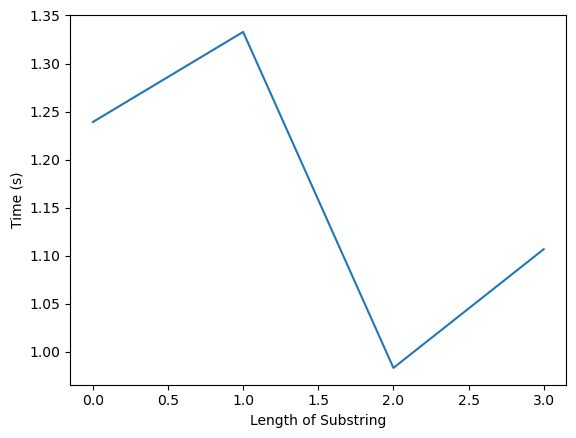

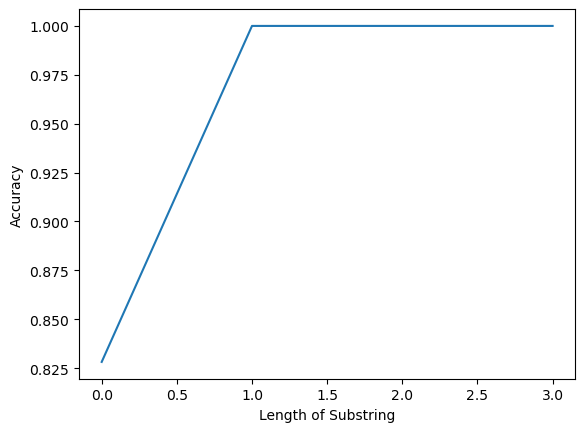

In [15]:
from matplotlib import pyplot as plt
times, accuracies = analyze_skwonk(start_length=50, stop_length=70, step_length=5, batch_length=1)
plt.plot(times)
plt.xlabel("Length of Substring")
plt.ylabel("Time (s)")
plt.show()
plt.plot(accuracies)
plt.xlabel("Length of Substring")
plt.ylabel("Accuracy")
plt.show()